# DLthon - 길찾은 오리들
## Base Settings

In [1]:
# importing the libraries
import keras, tensorflow as tf, numpy as np
import pathlib
from keras import layers
from matplotlib import pyplot as plt

# keras.mixed_precision.set_global_policy('mixed_float16')

2025-01-17 17:47:18.946494: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-17 17:47:18.956624: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737103638.966752  250596 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737103638.969825  250596 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-17 17:47:18.980861: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# loading the dataset
base_dir = pathlib.Path('jellyfish/Train_Test_Valid')

train_dataset = keras.utils.image_dataset_from_directory(
    base_dir / "train",
    image_size = (224, 224),
    batch_size = 64,
    label_mode='categorical')

val_dataset = keras.utils.image_dataset_from_directory(
    base_dir / "valid",
    image_size = (224, 224),
    batch_size = 64,
    label_mode='categorical')

test_dataset = keras.utils.image_dataset_from_directory(
    base_dir / "test",
    image_size = (224, 224),
    batch_size = 64,
    label_mode='categorical')

Found 900 files belonging to 6 classes.


I0000 00:00:1737103643.958845  250596 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9571 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 39 files belonging to 6 classes.
Found 40 files belonging to 6 classes.


In [3]:
# designing utility functions
def plot_training(history):
    fig = plt.figure(figsize=(10, 5))
    
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='valid')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_ylim(0, 5)

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(history.history['accuracy'], label='train')
    ax2.plot(history.history['val_accuracy'], label='valid')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')

    ax1.legend()
    ax2.legend()

    plt.show()

In [4]:
# designing callbacks
def callback_savemodel(model_name):
    return tf.keras.callbacks.ModelCheckpoint(
        model_name,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=0
    )

def callback_earlystop(patience):
    return tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='max'
    )



## Basemodel

여기에 ResNet50 결과 입력

## First Trial: EfficientNetV2L + Top Model
### Designing the Model

In [5]:
# designing the base model
conv_base = keras.applications.EfficientNetV2L(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

conv_base.trainable = False

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

# designing the model

def pretrained_model(): # this can be adjusted to be hyper-tunable
    inputs = keras.Input(shape=(224, 224, 3))
    # x = data_augmentation(inputs)
    x = conv_base(inputs, training=False)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(6, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    
    model.compile(loss='categorical_crossentropy',
                   optimizer='rmsprop',
                   metrics=['accuracy'])
    
    return model

In [6]:
pretrained = pretrained_model()

pretrained_history = pretrained.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=200,
    callbacks=[
        callback_savemodel('pretrained_model.keras'),
        callback_earlystop(80)
    ],
)

Epoch 1/200


I0000 00:00:1737103683.691495  250739 service.cc:148] XLA service 0x7f68101335f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737103683.691548  250739 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-01-17 17:48:04.593485: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737103687.796346  250739 cuda_dnn.cc:529] Loaded cuDNN version 90600
I0000 00:00:1737103715.883137  250739 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.2042 - loss: 34.9356 - val_accuracy: 0.1795 - val_loss: 6.5425
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 331ms/step - accuracy: 0.2717 - loss: 3.6450 - val_accuracy: 0.2564 - val_loss: 3.9986
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.2826 - loss: 2.7399 - val_accuracy: 0.2051 - val_loss: 2.9862
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.2675 - loss: 2.2692 - val_accuracy: 0.2308 - val_loss: 1.7164
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 280ms/step - accuracy: 0.3075 - loss: 1.7606 - val_accuracy: 0.2821 - val_loss: 1.6578
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.2779 - loss: 1.7716 - val_accuracy: 0.2564 - val_loss: 2.3235
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 332ms/step - accuracy: 0.2925 - loss: 2.3541 - val_accuracy: 0.3333 - val_loss: 2.9061
Epoch 8/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 306ms/step - accuracy: 0.2706 - loss: 2.1331 - val_accuracy: 0.4872 

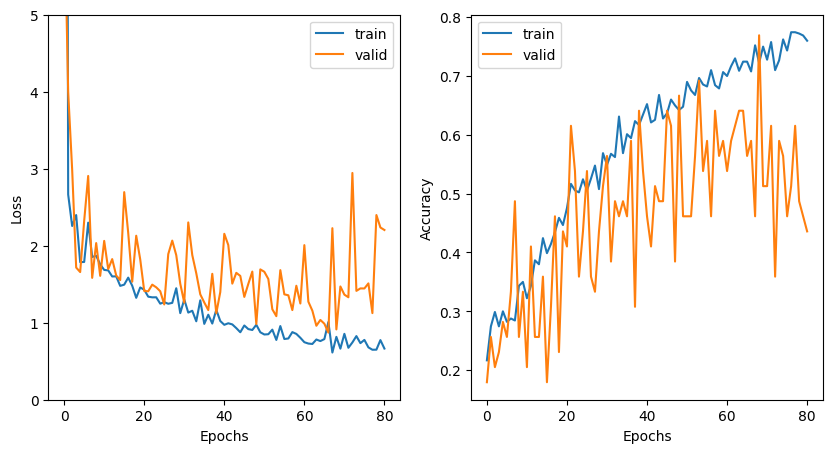

In [7]:
plot_training(pretrained_history)

In [8]:
pretrained_model = keras.models.load_model('pretrained_model.keras')
test_loss, test_acc = pretrained_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.2f}%, Test loss: {test_loss:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.7250 - loss: 1.1291
Test accuracy: 0.73%, Test loss: 1.13


## Second Trial: MobileNetV2 + Top Model

In [7]:
mobilenet_base = keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3))

mobilenet_base.trainable = False

def mobilenet_model():
    inputs = keras.Input(shape=(224, 224, 3))
    x = mobilenet_base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(6, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    model.compile(loss='categorical_crossentropy',
                   optimizer='rmsprop',
                   metrics=['accuracy'])

    return model

mobilenet = mobilenet_model()

mobilenet_history = mobilenet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=200,
    callbacks=[
        callback_savemodel('mobilenet_model.keras'),
        callback_earlystop(80)
    ],
)

Epoch 1/200


I0000 00:00:1737103275.521602  231299 service.cc:148] XLA service 0x7f957c010b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737103275.521634  231299 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-01-17 17:41:15.584760: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737103275.962636  231299 cuda_dnn.cc:529] Loaded cuDNN version 90600
2025-01-17 17:41:17.191353: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1618_0', 428 bytes spill stores, 684 bytes spill loads

2025-01-17 17:41:17.192308: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1618', 228 

 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2406 - loss: 2.8414

I0000 00:00:1737103282.543274  231299 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.2447 - loss: 2.5810

2025-01-17 17:41:28.400755: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1181_0', 8 bytes spill stores, 8 bytes spill loads

2025-01-17 17:41:28.591810: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1181', 8 bytes spill stores, 8 bytes spill loads

2025-01-17 17:41:28.688393: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1181', 252 bytes spill stores, 252 bytes spill loads



15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 660ms/step - accuracy: 0.2458 - loss: 2.5570 - val_accuracy: 0.2564 - val_loss: 1.6900
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3540 - loss: 1.5869 - val_accuracy: 0.2564 - val_loss: 1.6904
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4562 - loss: 1.3999 - val_accuracy: 0.2308 - val_loss: 1.7747
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4647 - loss: 1.3593 - val_accuracy: 0.3077 - val_loss: 1.7406
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4992 - loss: 1.3150 - val_accuracy: 0.2308 - val_loss: 1.9152
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5707 - loss: 1.1516 - val_accuracy: 0.2564 - val_loss: 1.8512
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5769 - loss: 1.1017 - val_accuracy: 0.3333 - val_loss: 1.5592
Epoch 8/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5755 - loss: 1.0841 - val_accuracy: 0.4103 - val

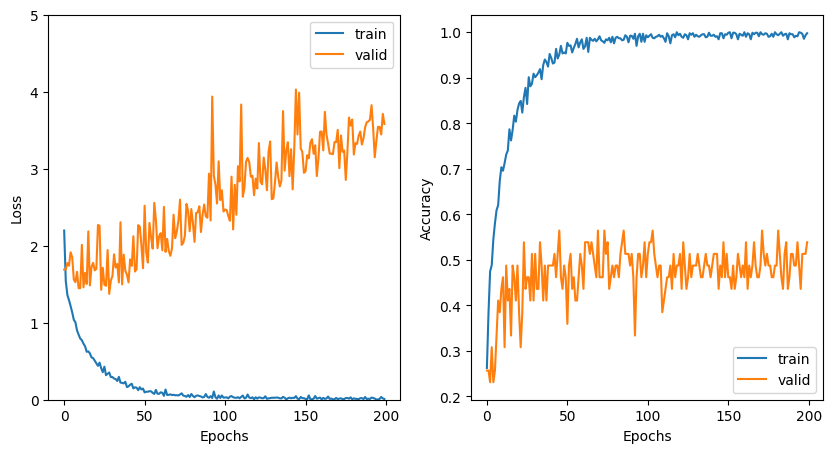

In [9]:
plot_training(mobilenet_history)

In [11]:
mobilenet_base = keras.models.load_model('mobilenet_model.keras')
test_loss, test_acc = mobilenet_base.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.2f}%, Test loss: {test_loss:.2f}")

2025-01-17 17:44:18.261280: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1181_0', 8 bytes spill stores, 8 bytes spill loads

2025-01-17 17:44:18.590716: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1181', 8 bytes spill stores, 8 bytes spill loads

2025-01-17 17:44:18.708402: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1181', 252 bytes spill stores, 252 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.6500 - loss: 1.1141
Test accuracy: 0.65%, Test loss: 1.11
